In [1]:
# Set up for the project
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import mnist
from keras import backend as K
from keras.models import model_from_json

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import imresize
from PIL import Image
from PIL import ImageFilter

import os
project_dir = os.getcwd()
model_dir = project_dir + "/models/"

vgg_model_loc = model_dir + "vgg11.h5"
vgg_json_loc = model_dir + "vgg11.json"

Using TensorFlow backend.


In [2]:
# Get the original dimension of dataset
(X_train_orig, Y_train), (X_test_orig, Y_test) = mnist.load_data()
print("Training data shape: ", X_train_orig.shape)
print("Training labels shape: ", Y_train.shape)
print("Testing data shape: ", X_test_orig.shape)
print("Test labels shape: ", Y_test.shape)

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Testing data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


The two randomly-chosen numbers are: 4975 2798
The size of the 2 randomly-chosen images are:  (32, 32) (32, 32)


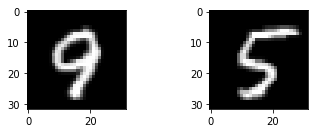

In [3]:
# Resize all images in test set
num_test = 10000
X_test = np.zeros((num_test,32,32))
for j in range(num_test):
    X_test[j] = imresize(X_test_orig[j],(32,32))

# Test with some random images
a = random.randint(0,num_test)
b = random.randint(0,num_test)
plt.subplot(221)
plt.imshow(X_test[a], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_test[b], cmap=plt.get_cmap('gray'))

print("The two randomly-chosen numbers are:", a,b)
print("The size of the 2 randomly-chosen images are: ",X_test[a].shape, X_test[b].shape)                                                    

In [4]:
# Preprocessing: reshape the image data into rows
def preprocess(arg_x_test,arg_y_test):
    img_rows = 32
    img_cols = 32
    num_classes = 10
    if K.image_data_format() == 'channels_first':
        arg_x_test = arg_x_test.reshape(arg_x_test.shape[0], 1, img_rows, img_cols)
    else:
        arg_x_test = arg_x_test.reshape(arg_x_test.shape[0], img_rows, img_cols, 1)

    arg_x_test = arg_x_test.astype('float32')

    # Preprocessing: subtract the mean image
    test_mean = np.mean(arg_x_test,axis=0)
    arg_x_test -= test_mean

    # convert class vectors to binary class matrices
    arg_y_test = keras.utils.to_categorical(arg_y_test,num_classes)
    
    return arg_x_test,arg_y_test

The shapes of one test images are: (32, 32)
The shape of the new numpy arrays are (32, 32) (32, 32)


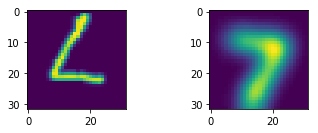

In [5]:
# Test bidirectional transformation: numpy array-->PIL image and PIL image-->numpy array
print("The shapes of one test images are:", X_test[0].shape)
img_rot = Image.fromarray(X_test[0])
img_blur = Image.fromarray(X_test[0]).convert('L')

img_rot = img_rot.rotate(180)
img_blur = img_blur.filter(ImageFilter.GaussianBlur(radius=3))

new_array_rot = np.array(img_rot)
new_array_blur = np.array(img_blur)

plt.subplot(221)
plt.imshow(new_array_rot)
plt.subplot(222)
plt.imshow(new_array_blur)

print("The shape of the new numpy arrays are", new_array_rot.shape,new_array_blur.shape)

In [6]:
# Build the functionality for batch rotating all images from the test set
def rotate_testset(degree):
    new_testset = np.zeros((num_test,32,32))
    for i in range(num_test):
        img = Image.fromarray(X_test[i])
        img = img.rotate(degree)
        new_testset[i] = np.array(img)
    return new_testset  

(10000, 32, 32)


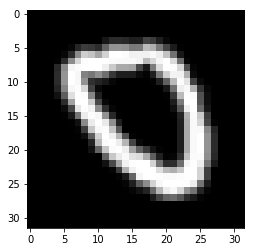

In [7]:
# Test for batch rotating functionality
X_test_ninty = rotate_testset(90)
print(X_test_ninty.shape)
a = random.randint(0,num_test)
plt.imshow(X_test_ninty[a], cmap=plt.get_cmap('gray'))

In [8]:
# Build the functionality for batch GaussianBlur all images from the test set
def gaussianblur_testset(radius):
    new_testset = np.zeros((num_test,32,32))
    for i in range(num_test):
        img = Image.fromarray(X_test[i]).convert('L')
        img = img.filter(ImageFilter.GaussianBlur(radius))
        new_testset[i] = np.array(img)
    return new_testset  

(10000, 32, 32)


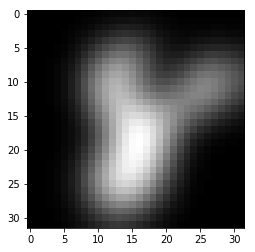

In [9]:
# Test for batch GaussianBlur functionality
X_test_radius_three = gaussianblur_testset(3)
print(X_test_radius_three.shape)
a = random.randint(0,num_test)
plt.imshow(X_test_radius_three[a], cmap=plt.get_cmap('gray'))

In [10]:
# Define a model loading function
def load_vgg_model():
    # load json and create model
    json_file = open(vgg_json_loc,"r")
    loaded_vgg_json = json_file.read()
    json_file.close()
    loaded_vgg11 = model_from_json(loaded_vgg_json)
    # load weights into new model
    loaded_vgg11.load_weights(vgg_model_loc)
    return loaded_vgg11

In [ ]:
def rotation_vs_acc(rotation_range):
    rotation_results = {}
    for current_rt in rotation_range:
        # TODO: 
        # 1. Load the pre-trained model 
        # 2. Generate the corresponding test set and reshape it
        # 3. Fit the test set in and get test accuracy
        # 4. rotation_results[str(rotation)] = accuracy
        model = load_vgg_model()
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        new_X_test = rotate_testset(current_rt)
        rs_X_test, rs_Y_test = preprocess(new_X_test, Y_test)
        score = model.evaluate(rs_X_test,rs_Y_test,verbose=0)
        rotation_results[current_rt] = score[1]*100
    return rotation_results

def blur_vs_acc(radius_range):
    radius_results = {}
    for current_rd in radius_range:
        # TODO: 
        # 1. Load the pre-trained model 
        # 2. Generate the corresponding test set and reshape it
        # 3. Fit the test set in and get test accuracy
        # 4. rotation_results[str(radius)] = accuracy
        model = load_vgg_model()
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        new_X_test = gaussianblur_testset(current_rd)
        rs_X_test, rs_Y_test = preprocess(new_X_test, Y_test)
        score = model.evaluate(rs_X_test,rs_Y_test,verbose=0)
        radius_results[current_rd] = score[1]*100
    return radius_results


rotation_range = list(range(-45,50,5))
radius_range = list(range(7))

rotation_results = rotation_vs_acc(rotation_range)
radius_results = blur_vs_acc(radius_range)


print("Rotation results are:", rotation_results)
print("\n")
print("Radius results are:", radius_results)   

In [ ]:
# Plot Rotation/blur vs Test Accuracy
rotation_x, rotation_y = zip(*sorted(rotation_results.items()))
blur_x, blur_y = zip(*sorted(radius_results.items()))

subplot(221)
plt.plot(rotation_x,rotation_x)
plt.title('Rotation vs Test Accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Rotation Degrees')
plt.show()

subplot(222)
plt.plot(rotation_x,rotation_x)
plt.title('Blur vs Test Accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Blur Radius')
plt.show()